### __Imports__

In [1034]:
import math
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import random
from typing import List

from sklearn.model_selection import train_test_split

### __Graphing__

In [1035]:
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in the graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    # Creates a graphviz visualization of the computational graph
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    
    # Add nodes to graph
    for n in nodes:
        uid = str(id(n))
        # Node label: data value | operation
        label = f"{n.label} | data: {n.data:.4f} | grad: {n.grad:.4f}"
        dot.node(name=uid, label=label, shape='record')
        
        if n._op:
            # Add operation label with circle shape
            dot.node(name=uid + n._op, label=n._op, shape='circle')
            dot.edge(uid + n._op, uid)
    
    # Add edges to graph
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [1036]:
def f(x):
    return 3*x**2 - 2*x + 1

In [1037]:
f(3.0)

22.0

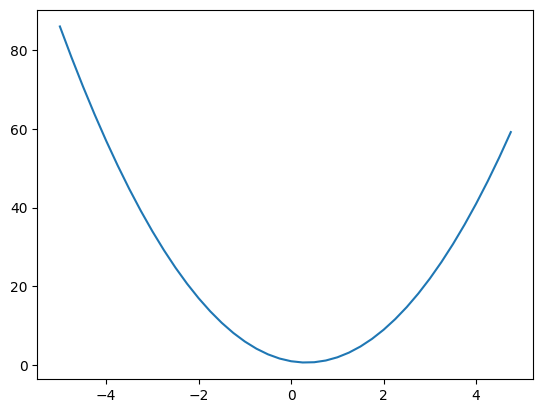

In [1038]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [1039]:
h = 0.00001
x = -3.0
(f(x + h) - f(x)) / h

-19.999970000128542

In [1040]:
a = 2. 
b = -3.
c = 10.
d = a*b + c
print(d)

4.0


In [1041]:
d1 = a*b + c
a += h
d2 = a*b + c
print(d2)

3.9999699999999994


In [1042]:
(d2 - d1) / h

-3.000000000064062

In [1043]:
a

a + b 
a * b

-6.000030000000001

### __Value Class__

In [1044]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = _children
        self._op = _op
        self.label = label
        self.visited = set()

    def __repr__(self):
        # if show_grad:
        return f"Value(data={self.data}, grad={self.grad})"
        # return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __sub__(self, other):
        out = Value(self.data.__add__(-1 * other.data), (self, other), '-')
        return out
    # figure if this gets automatically handled or not
    # soln: neural nets don't need subtraction
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    def tanh(self):
        x_data = self.data
        t = math.tanh(x_data)
        out = Value(t, (self,), "tanh")
        return out

    def sigmoid(self):
        x_data = self.data
        t = 1 / (1 + math.exp(-x_data))
        out = Value(t, (self,), "sigmoid")
        return out
    
    def relu(self):
        x_data = self.data
        t = 0 if x_data <= 0 else x_data
        out = Value(t, (self,), "relu")
        return out
    
    def trace_back(self, node):
        if node in self.visited:
            return
        self.visited.add(node)
        
        if node._prev:
            if len(node._prev) > 1:
                if node._op == '+':
                    if node._prev[0] != node._prev[1]:
                        node._prev[0].grad += node.grad * 1.0
                        node._prev[1].grad += node.grad * 1.0
                    else:
                        node._prev[0].grad += node.grad * 1.0
                elif node._op == '-':
                    if node._prev[0] != node._prev[1]:
                        node._prev[0].grad += node.grad * 1.0
                        node._prev[1].grad += node.grad * 1.0
                    else:
                        node._prev[0].grad += node.grad * 1.0
                else:
                    if node._prev[0] != node._prev[1]: # or take a set
                        node._prev[0].grad += node.grad * node._prev[1].data
                        node._prev[1].grad += node.grad * node._prev[0].data
                    else:
                        node._prev[0].grad += node.grad * node._prev[0].data

                node.trace_back(node._prev[0])
                node.trace_back(node._prev[1])
            elif len(node._prev) == 1:
                if node._op == "tanh":
                    # print("tanh op found")
                    node._prev[0].grad += node.grad * (1 - node.data * node.data)
                elif node._op == "relu":
                    # print("relu op found")
                    if node._prev[0].data > 0:
                        node._prev[0].grad += node.grad * 1
                elif node._op == "sigmoid":
                    # print("sigmoid op found")
                    node._prev[0].grad += node.grad * node.data * (1 - node.data)
                else:
                    raise ValueError("Unknown operation found, not supported!")

                node.trace_back(node._prev[0])

    def backward(self):
        self.grad = 1.0
        self.visited = set()
        self.trace_back(self)

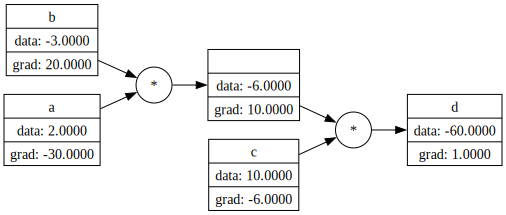

In [1045]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a * b * c; d.label = 'd'
# print(d._prev)
# d._prev[0].label = 'ab'
# d._prev[0].backward()
d.backward()
# print(d.data)
draw_dot(d)

### __Neuron Class__

In [1046]:
class Neuron:
    def __init__(self, n_units: int):
        self.weights =  [Value(random.gauss(0, 1)) for _ in range(n_units)]
        self.bias = Value(random.gauss(0, 1))
    
    def __repr__(self):
        return (
            f"Neuron:\n"
            f"  weights: {self.weights}\n"
            f"  bias: {self.bias}"
        )
    
    def forward(self, x: List[Value]) -> List[Value]:
        assert len(x) == len(self.weights), "Input vector's length must be equal to n_units of the neuron"
        res = Value(0.0)
        for i in range(len(x)):
            res += self.weights[i] * x[i]

        res += self.bias
        return res
    
    def __call__(self, x: List[Value]):
        return self.forward(x)

In [1047]:
input_arr = [Value(1), Value(2), Value(3)]
n1 = Neuron(3)
n2 = Neuron(1)
n3 = Neuron(1)

print(n1)
print(n2)
print(n3)

Neuron:
  weights: [Value(data=0.6469998252862488, grad=0.0), Value(data=0.872230331574988, grad=0.0), Value(data=0.5451874647612666, grad=0.0)]
  bias: Value(data=0.1402622432746369, grad=0.0)
Neuron:
  weights: [Value(data=0.9535065450702134, grad=0.0)]
  bias: Value(data=1.4992149186059889, grad=0.0)
Neuron:
  weights: [Value(data=0.4250734764106123, grad=0.0)]
  bias: Value(data=-0.15546314509357193, grad=0.0)


In [1048]:
o1 = n1(input_arr)
print(o1)
o1_list = [o1]

o2 = n2(o1_list)
o2_list = [o2]

o3 = n3(o2_list)
print(o3)

Value(data=4.167285125994661, grad=0.0)
Value(data=2.1708571114285546, grad=0.0)


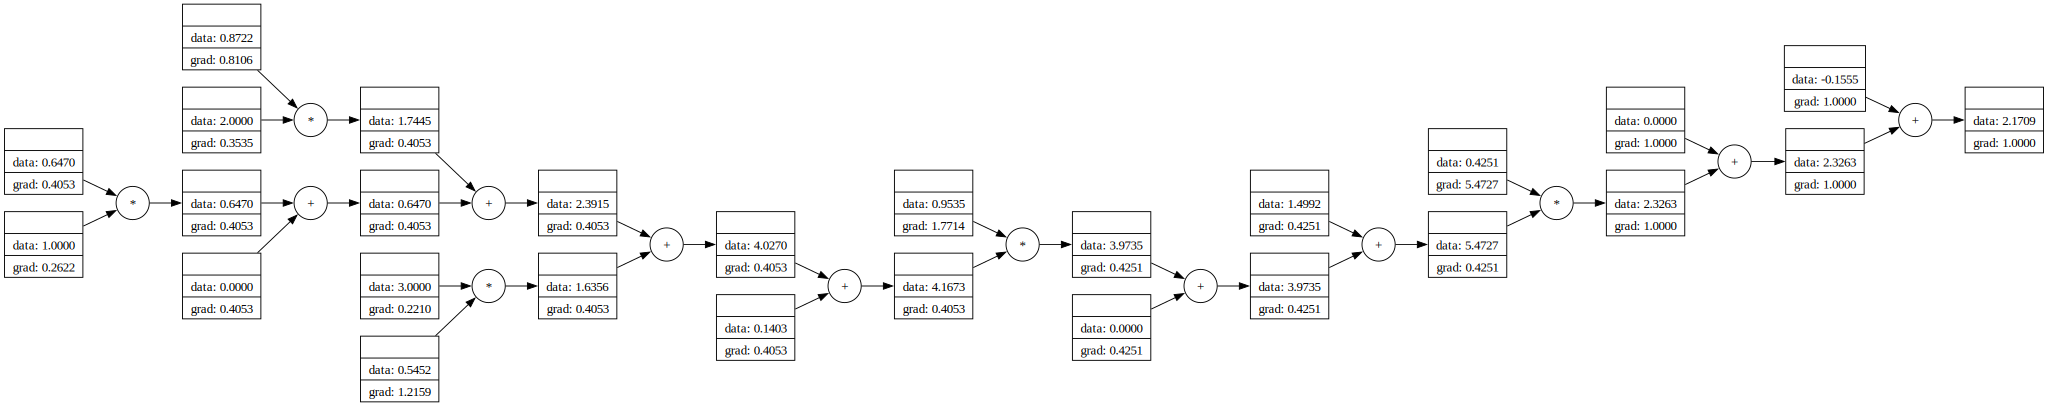

In [1049]:
draw_dot(o3)
o3.backward()
draw_dot(o3)

In [1050]:
n1

Neuron:
  weights: [Value(data=0.6469998252862488, grad=0.4053103418932678), Value(data=0.872230331574988, grad=0.8106206837865356), Value(data=0.5451874647612666, grad=1.2159310256798035)]
  bias: Value(data=0.1402622432746369, grad=0.4053103418932678)

### __Layer Class__

In [1051]:
class NeuronLayer:
    def __init__(self, in_features: int, out_features: int):
        self.in_features = in_features
        self.out_features = out_features
        self.layer = [Neuron(in_features) for _ in range(out_features)]
    
    def forward(self, x: List[Value]) -> List[Value]:
        assert len(x) == self.in_features, "Input vector's length must be equal to n_units of the neuron"
        res = []
        for i in range(self.out_features):
            neuron_i = self.layer[i]
            res_i = Value(0.0)
            for j in range(self.in_features):
                res_i += x[j] * neuron_i.weights[j]
            res_i += neuron_i.bias
            res.append(res_i)

        return res
    
    def __call__(self, x: List[Value]):
        return self.forward(x)

    def __repr__(self):
        out_str = "NeuronLayer:\n"
        for i in range(self.out_features):
            neuron = self.layer[i]
            # out_str += f"Neuron_{i+1}\n" + str(neuron) + "\n"
            out_str += str(neuron) + "\n"
        return out_str

In [1052]:
lst = ["abc", "def", "ghi"]
print("\n".join(lst))

abc
def
ghi


In [1053]:
str(n1)

'Neuron:\n  weights: [Value(data=0.6469998252862488, grad=0.4053103418932678), Value(data=0.872230331574988, grad=0.8106206837865356), Value(data=0.5451874647612666, grad=1.2159310256798035)]\n  bias: Value(data=0.1402622432746369, grad=0.4053103418932678)'

In [1054]:
input_arr

[Value(data=1, grad=0.26223572039165405),
 Value(data=2, grad=0.35352397390033674),
 Value(data=3, grad=0.22097011773831285)]

In [1055]:
layer = NeuronLayer(3, 2)
print(layer)

print(layer(input_arr))

NeuronLayer:
Neuron:
  weights: [Value(data=-1.5618344967001638, grad=0.0), Value(data=0.7205617077162254, grad=0.0), Value(data=-2.086005919637503, grad=0.0)]
  bias: Value(data=0.5011089441960167, grad=0.0)
Neuron:
  weights: [Value(data=-1.423485405417916, grad=0.0), Value(data=0.5389984751933388, grad=0.0), Value(data=0.36901312136573305, grad=0.0)]
  bias: Value(data=0.3839462366731696, grad=0.0)

[Value(data=-5.877619895984206, grad=0.0), Value(data=1.1454971457391303, grad=0.0)]


### __Activation Functions__

In [1056]:
# activation functions
def tanh(x: List[Value]) -> List[Value]:
    return [i.tanh() for i in x]

def relu(x: List[Value]) -> List[Value]:
    return [i.relu() for i in x]

def sigmoid(x: List[Value]) -> List[Value]:
    return [i.sigmoid() for i in x]

### __Activation Layer__

In [1057]:
class ActivationLayer:
    def __init__(self, activation: str):
        activations = {
            "tanh": tanh,
            "relu": relu,
            "sigmoid": sigmoid
        }
        if activation not in activations:
            raise ValueError(f"Unsupported activation function: {activation}")
        
        self.activation = activations[activation]

    def __call__(self, x: List[Value]) -> List[Value]:
        return self.activation(x)

### __MLP Class__

In [1058]:
class MLP:
    def __init__(self):
        self.layers: List[NeuronLayer] = []
    
    def add_layer(self, in_features: int, out_features: int):
        layer = NeuronLayer(in_features=in_features, out_features=out_features)
        self.layers.append(layer)
    
    def add_activation_layer(self, activation_layer: ActivationLayer):
        self.layers.append(activation_layer)

    def forward(self, x: List[Value]) -> List[Value]:
        out_l = x
        for i in range(len(self.layers)):
            curr_layer = self.layers[i]
            out_l = curr_layer(out_l)
        
        return out_l
    
    def __call__(self, x: List[Value]):
        return self.forward(x)
    
    def __repr__(self):
        out_str = "MLP:\n"
        for i in range(len(self.layers)):
            layer = self.layers[i]
            out_str += str(layer) + "\n"
        return out_str

In [1059]:
mlp = MLP()
mlp.add_layer(3, 2)
mlp.add_layer(2, 1)
print(mlp)
mlp_res = mlp(input_arr)

MLP:
NeuronLayer:
Neuron:
  weights: [Value(data=2.2567400853445245, grad=0.0), Value(data=-1.1002874262338338, grad=0.0), Value(data=-1.9541185977124576, grad=0.0)]
  bias: Value(data=0.7691610150218532, grad=0.0)
Neuron:
  weights: [Value(data=-0.5105925661697338, grad=0.0), Value(data=-0.47471093469993764, grad=0.0), Value(data=-0.22718399716185045, grad=0.0)]
  bias: Value(data=-0.5188392495707578, grad=0.0)

NeuronLayer:
Neuron:
  weights: [Value(data=-3.2971786917198855, grad=0.0), Value(data=2.408162026033939, grad=0.0)]
  bias: Value(data=0.49802055713986654, grad=0.0)




In [1060]:
draw_dot(mlp_res[0])
mlp_res[0].backward()

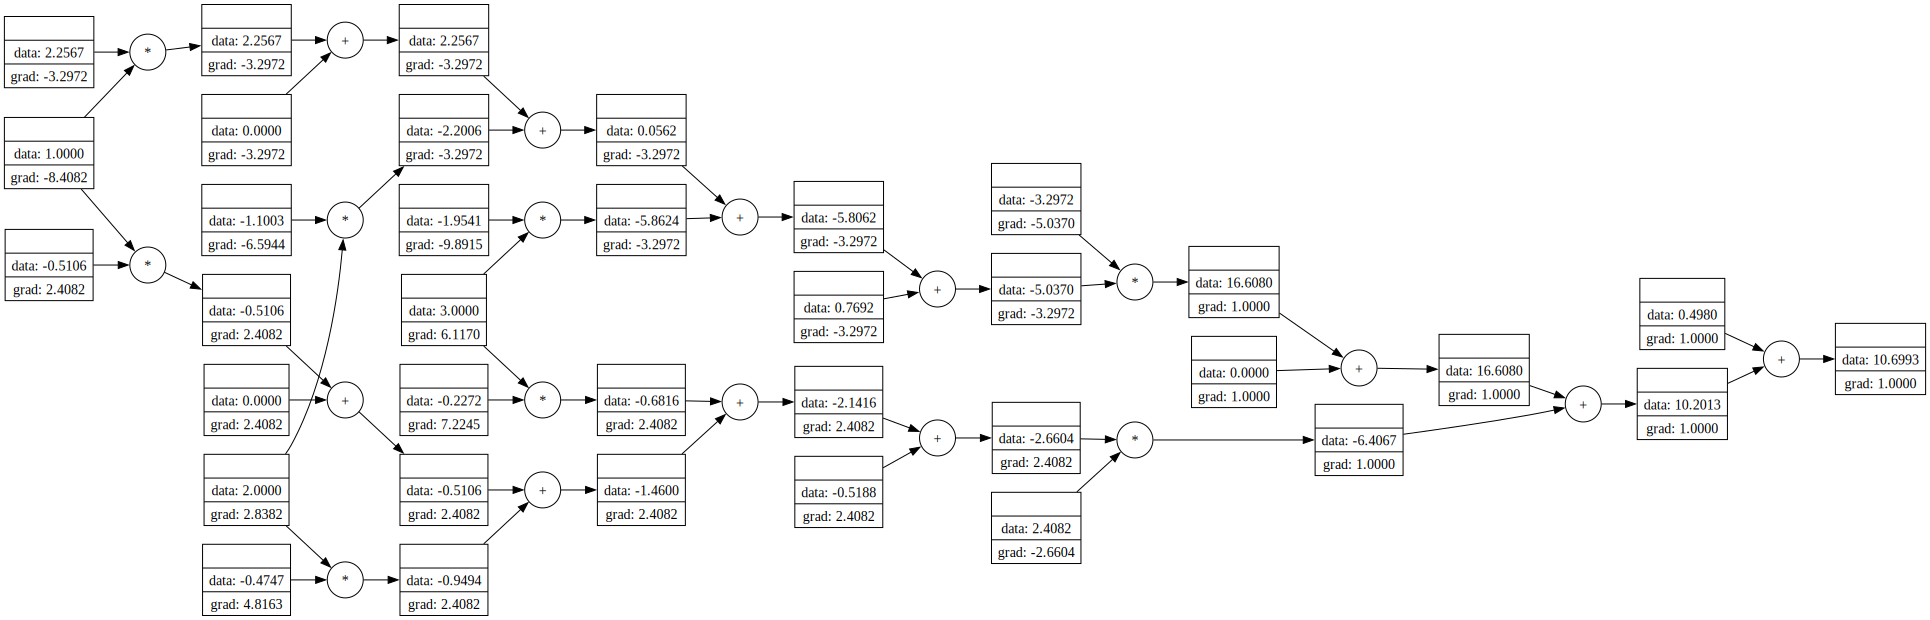

In [1061]:
draw_dot(mlp_res[0])

In [1062]:
k: float = 0
print(k)
print(type(k))

0
<class 'int'>


In [1063]:
input_arr

[Value(data=1, grad=-8.408229230381602),
 Value(data=2, grad=2.838187384158382),
 Value(data=3, grad=6.1169524443216)]

In [1064]:
act = ActivationLayer("tanh")
act(input_arr)

[Value(data=0.7615941559557649, grad=0.0),
 Value(data=0.9640275800758169, grad=0.0),
 Value(data=0.9950547536867305, grad=0.0)]

### __Loss Functions__

In [1065]:
# loss functions

def MSELoss(y_pred: List[Value], y_target: List[Value]) -> Value:
    assert len(y_pred) == len(y_target), "Length of y_pred should be equal to that of y_target"
    loss = Value(0.0)
    m = len(y_pred)
    for i in range(len(y_pred)):
        diff = y_pred[i] - y_target[i]
        loss += diff * diff
    
    # loss.data /= 2 * m
    # TODO: To add this normalization later, right now we can work without it, just to test grad desc.
    return loss

# def CrossEntropyLoss(y_pred: List[Value], )


### __Optimizer Class__

In [1066]:
class Optimizer:
    def __init__(self, mlp_model: MLP, lr: float = 0.01):
        self.mlp = mlp_model
        self.lr = lr
    
    def zero_grad(self):
        for layer in self.mlp.layers:
            if isinstance(layer, NeuronLayer):
                for neuron in layer.layer:
                    neuron.bias.grad = 0.0
                    for weight in neuron.weights:
                        weight.grad = 0.0
    
    def step(self):
        for layer in self.mlp.layers:
            if isinstance(layer, NeuronLayer):
                for neuron in layer.layer:
                    neuron.bias.data -= self.lr * neuron.bias.grad
                    for weight in neuron.weights:
                        weight.data -= self.lr * weight.grad

In [1067]:
print(mlp)
# optimizer = Optimizer(mlp, 0.01)
# optimizer.zero_grad()
# print(mlp)

MLP:
NeuronLayer:
Neuron:
  weights: [Value(data=2.2567400853445245, grad=-3.2971786917198855), Value(data=-1.1002874262338338, grad=-6.594357383439771), Value(data=-1.9541185977124576, grad=-9.891536075159657)]
  bias: Value(data=0.7691610150218532, grad=-3.2971786917198855)
Neuron:
  weights: [Value(data=-0.5105925661697338, grad=2.408162026033939), Value(data=-0.47471093469993764, grad=4.816324052067878), Value(data=-0.22718399716185045, grad=7.224486078101817)]
  bias: Value(data=-0.5188392495707578, grad=2.408162026033939)

NeuronLayer:
Neuron:
  weights: [Value(data=-3.2971786917198855, grad=-5.037029545238663), Value(data=2.408162026033939, grad=-2.660405676625918)]
  bias: Value(data=0.49802055713986654, grad=1.0)




In [1068]:
optimizer = Optimizer(mlp, 0.01)
optimizer.step()

In [1069]:
test_bias = mlp.layers[0].layer[0].bias
print(test_bias)

trial_run_bias = Value(test_bias.data - 0.01 * test_bias.grad)
print(trial_run_bias)

# ran after a step from optimizer

Value(data=0.802132801939052, grad=-3.2971786917198855)
Value(data=0.8351045888562508, grad=0.0)


In [1070]:
test_bias = mlp.layers[0].layer[0].bias
print(test_bias)

trial_run_bias = Value(test_bias.data - 0.01 * test_bias.grad)
print(trial_run_bias)

# ran before a step from optimizer

Value(data=0.802132801939052, grad=-3.2971786917198855)
Value(data=0.8351045888562508, grad=0.0)


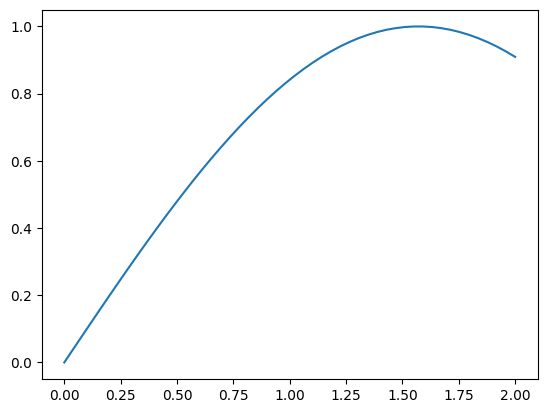

In [1071]:
X = np.linspace(0, 2, 50)
y = np.sin(X)

plt.plot(X, y)

In [1072]:
SinModel = MLP()
SinModel.add_layer(1, 16)
SinModel.add_activation_layer(ActivationLayer("relu"))
SinModel.add_layer(16, 16)
SinModel.add_activation_layer(ActivationLayer("relu"))
SinModel.add_layer(16, 8)
SinModel.add_activation_layer(ActivationLayer("relu"))
SinModel.add_layer(8, 1)

In [1073]:
SinModel

# TODO: Add a param to ask if want to specifiy neurons in each layer as well, otherwise just put info about the layers.

MLP:
NeuronLayer:
Neuron:
  weights: [Value(data=0.40457603185083973, grad=0.0)]
  bias: Value(data=-0.26643721305717805, grad=0.0)
Neuron:
  weights: [Value(data=-1.2742846751875865, grad=0.0)]
  bias: Value(data=2.3453768430405644, grad=0.0)
Neuron:
  weights: [Value(data=-0.7539360017359394, grad=0.0)]
  bias: Value(data=-0.05469134725844713, grad=0.0)
Neuron:
  weights: [Value(data=0.8155300025854427, grad=0.0)]
  bias: Value(data=-0.7364063515747161, grad=0.0)
Neuron:
  weights: [Value(data=-1.520058091070681, grad=0.0)]
  bias: Value(data=1.5386801073209195, grad=0.0)
Neuron:
  weights: [Value(data=1.5888613724973564, grad=0.0)]
  bias: Value(data=-0.6537415229769364, grad=0.0)
Neuron:
  weights: [Value(data=-1.2907499373181197, grad=0.0)]
  bias: Value(data=0.00693249390103262, grad=0.0)
Neuron:
  weights: [Value(data=-1.3725820867734844, grad=0.0)]
  bias: Value(data=-0.5606725365992694, grad=0.0)
Neuron:
  weights: [Value(data=-0.19677968862211392, grad=0.0)]
  bias: Value(dat

In [1074]:
X = [Value(i) for i in X]
X[0]

Value(data=0.0, grad=0.0)

In [1075]:
y = [Value(i) for i in y]
y[6]

Value(data=0.24245732992136676, grad=0.0)

In [1076]:
loss_fn = MSELoss
optimizer = Optimizer(SinModel, lr=0.01)

In [1077]:
# TODO: Add batch processing

In [1078]:
epochs = 100

for epoch in range(epochs):
    y_pred = [SinModel([i])[0] for i in X]
    # print(y_pred[:5])
    # print(y[:5])
    # print(len(y_pred)); print(len(y))
    loss = loss_fn(y_pred, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(loss)

Value(data=1101.663709108926, grad=1.0)
Value(data=900507.8713774924, grad=1.0)
Value(data=104878454817577.6, grad=1.0)
Value(data=24894010609844.516, grad=1.0)
Value(data=6223502652464.76, grad=1.0)
Value(data=1555875663119.823, grad=1.0)
Value(data=388968915783.5873, grad=1.0)
Value(data=97242228949.52846, grad=1.0)
Value(data=24310557241.01381, grad=1.0)
Value(data=6077639313.8851185, grad=1.0)
Value(data=1519409832.1029518, grad=1.0)
Value(data=379852461.65740895, grad=1.0)
Value(data=94963119.0460231, grad=1.0)
Value(data=23740783.393176604, grad=1.0)
Value(data=5935199.479964998, grad=1.0)
Value(data=1483803.5016621023, grad=1.0)
Value(data=370954.5070863779, grad=1.0)
Value(data=92742.25844244663, grad=1.0)
Value(data=23189.19628146377, grad=1.0)
Value(data=5800.930741218061, grad=1.0)
Value(data=1453.8643561566341, grad=1.0)
Value(data=367.09775989127803, grad=1.0)
Value(data=95.406110824939, grad=1.0)
Value(data=27.483198558354225, grad=1.0)
Value(data=10.502470491708044, grad

In [1079]:
y_pred = [SinModel([i])[0] for i in X]
    # print(y_pred[:5])
    # print(y[:5])
    # print(len(y_pred)); print(len(y))
loss = loss_fn(y_pred, y)

In [1080]:
def plot_predictions(X: List[Value], y_actual: List[Value], y_pred: List[Value]):
    X = [i.data for i in X]
    y_actual = [i.data for i in y_actual]
    y_pred = [i.data for i in y_pred]

    plt.figure(figsize=(10, 7))
    plt.plot(X, y_actual, label="actual")
    plt.plot(X, y_pred, label="predicted")
    plt.legend()
    plt.show()    

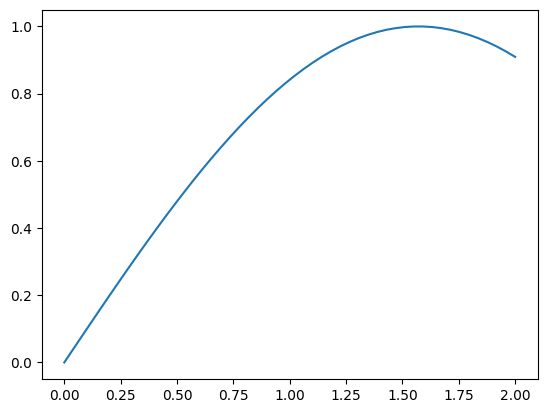

In [1081]:
plt.plot([i.data for i in X], [i.data for i in y])

In [1082]:
print([i.data for i in y[:25]])
print([i.data for i in y_pred[:25]])

[np.float64(0.0), np.float64(0.04080499432827389), np.float64(0.08154201809487689), np.float64(0.12214321395950552), np.float64(0.16254095083599351), np.float64(0.20266793654820092), np.float64(0.24245732992136676), np.float64(0.28184285212220994), np.float64(0.3207588970623151), np.float64(0.359140640680899), np.float64(0.39692414892492234), np.float64(0.4340464842466773), np.float64(0.470445810441457), np.float64(0.5060614956506707), np.float64(0.5408342133588315), np.float64(0.5747060412161791), np.float64(0.6076205575223265), np.float64(0.6395229352102129), np.float64(0.6703600331738099), np.float64(0.7000804847874535), np.float64(0.7286347834693503), np.float64(0.7559753651467324), np.float64(0.7820566874852943), np.float64(0.8068353057509381), np.float64(0.8302699451774576)]
[np.float64(0.7029085849818575), np.float64(0.7029085849818575), np.float64(0.7029085849818575), np.float64(0.7029085849818575), np.float64(0.7029085849818575), np.float64(0.7029085849818575), np.float64(0.70

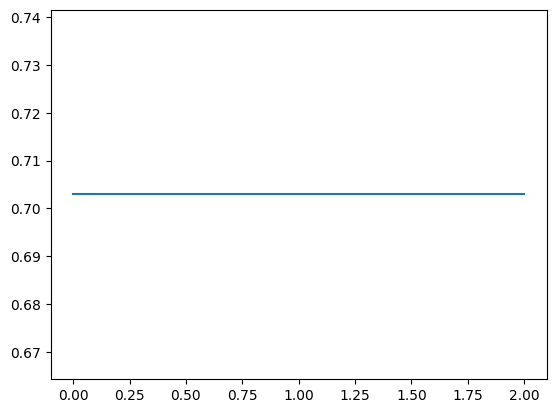

In [1083]:
plt.plot([i.data for i in X], [i.data for i in y_pred])

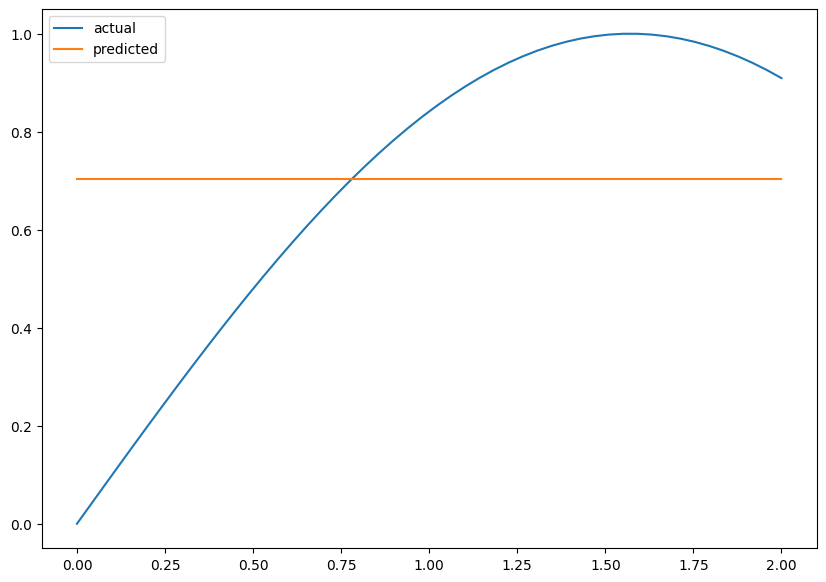

In [1084]:
plot_predictions(X, y, y_pred)

In [1085]:
SinModel.layers[4]

NeuronLayer:
Neuron:
  weights: [Value(data=0.04583177101890994, grad=0.0), Value(data=-1.8324396307685487, grad=0.0), Value(data=-0.8352018658599419, grad=0.0), Value(data=1.7222150015010582, grad=0.0), Value(data=0.9563915368628014, grad=0.0), Value(data=-0.49838546970526315, grad=0.0), Value(data=0.5703001899037203, grad=0.0), Value(data=-1.4245925850947505, grad=0.0), Value(data=0.8622664705979137, grad=0.0), Value(data=-0.6833405584487253, grad=0.0), Value(data=-2.490743322061014, grad=0.0), Value(data=0.29993018687009265, grad=0.0), Value(data=-0.7808140898536985, grad=0.0), Value(data=1.5242997543183427, grad=0.0), Value(data=-0.6400489255825508, grad=0.0), Value(data=-1.565108553961747, grad=0.0)]
  bias: Value(data=-2.570114049292637, grad=0.0)
Neuron:
  weights: [Value(data=-480.3376415799587, grad=0.0), Value(data=-493.76333367054986, grad=0.0), Value(data=-1008.5173754541759, grad=0.0), Value(data=-0.9410492686901892, grad=0.0), Value(data=-197.05697028301464, grad=0.0), Va

In [1086]:
model = MLP()
model.add_layer(1, 1)
model.add_activation_layer(ActivationLayer("relu"))
model.add_layer(1, 1)

model

MLP:
NeuronLayer:
Neuron:
  weights: [Value(data=0.779362551691382, grad=0.0)]
  bias: Value(data=1.3095861136112164, grad=0.0)

NeuronLayer:
Neuron:
  weights: [Value(data=0.35021562745311813, grad=0.0)]
  bias: Value(data=0.10625086835189575, grad=0.0)


In [1087]:
x_test = [Value(15.0)]
y_test = [Value(30.0)]

In [1088]:
y_test_pred = model(x_test)
y_test_pred

[Value(data=4.659062566645047, grad=0.0)]

In [1089]:
loss = loss_fn(y_test_pred, y_test)
loss

Value(data=642.1631100012103, grad=0.0)

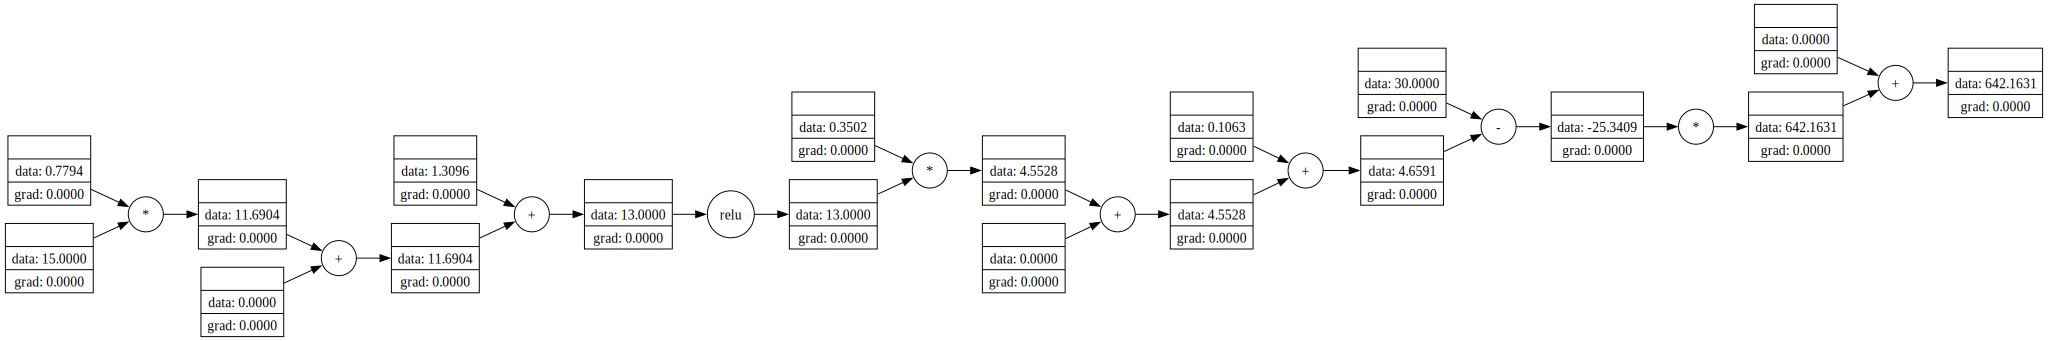

In [1090]:
draw_dot(loss)

In [1091]:
loss.backward()

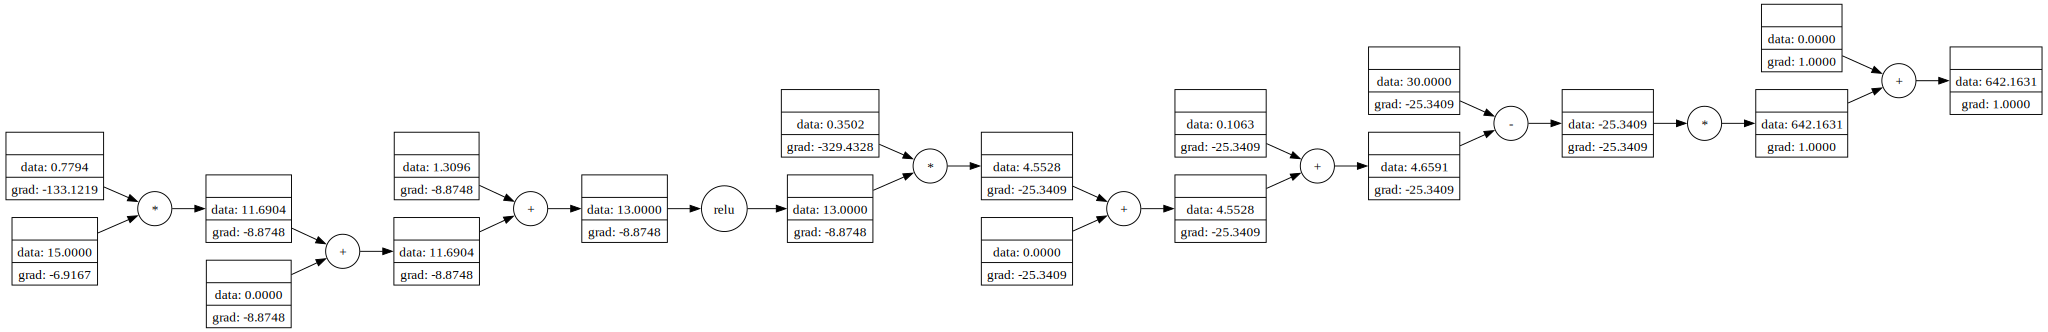

In [1092]:
draw_dot(loss)